# Neural Collaborative Filtering for Personalized Ranking

- neural collaborative filtering *(NCF)*
  - with **implicit** feedback
  - generates a ranked recommendation list

## The NeuMF model

![NeuMF](images/rec-neumf.svg)

- two subnetworks

### generalized matrix factorization (GMF) 
$$
\begin{split}\mathbf{x} = \mathbf{p}_u \odot \mathbf{q}_i \\
\hat{y}_{ui} = \alpha(\mathbf{h}^\top \mathbf{x}),\end{split}
$$
where
- $\odot$ is the element-wise product *(Hadamard product)*
- $\mathbf{P} \in \mathbb{R}^{m \times k}$ and $\mathbf{Q} \in \mathbb{R}^{n \times k}$ are the embedding matrices of users and items
- $\mathbf{p}_u \in \mathbb{R}^{ k}$ is the $u^\textrm{th}$ row of $\mathbf{P}$
- $\mathbf{q}_i \in \mathbb{R}^{ k}$ is the $i^\textrm{th}$ row of $\mathbf{Q}$
- $\mathbf{h} \in \mathbb{R}^{k}$ is a weight vector
- $\alpha$ is an activation function
- $\hat{y}_{ui}$ is the predicted rating of user $u$ for item $i$
### MLP
- not share embeddings with GMF
$$
\begin{split}\begin{aligned}
z^{(1)} &= \phi_1(\mathbf{U}_u, \mathbf{V}_i) = \left[ \mathbf{U}_u, \mathbf{V}_i \right] \\
\phi^{(2)}(z^{(1)})  &= \alpha^1(\mathbf{W}^{(2)} z^{(1)} + b^{(2)}) \\
&... \\
\phi^{(L)}(z^{(L-1)}) &= \alpha^L(\mathbf{W}^{(L)} z^{(L-1)} + b^{(L)})) \\
\hat{y}_{ui} &= \alpha(\mathbf{h}^\top\phi^L(z^{(L-1)}))
\end{aligned}\end{split}
$$
where
- $\mathbf{U} \in \mathbb{R}^{m \times k}$ and $\mathbf{V} \in \mathbb{R}^{n \times k}$ are the embedding matrices of users and items
- $\mathbf{W}^*, b^*, \alpha^*$ are the weight matrix, bias vector, and activation function 
- $\phi^*$ denotes the function of the corresponding layer
  - $\phi_1$ is the concatenation of $\mathbf{U}_u$ and $\mathbf{V}_i$
- $\hat{y}_{ui}$ is the predicted rating of user $u$ for item $i$
### NeuMF Layer
$$
\hat{y}_{ui} = \sigma(\mathbf{h}^\top[\mathbf{x}, \phi^L(z^{(L-1)})]).
$$
where
- $\sigma$ is the sigmoid function
- $\mathbf{x}$ is the element-wise product of $\mathbf{p}_u$ and $\mathbf{q}_i$
- $\phi^L(z^{(L-1)})$ is the output of the last layer of MLP
- $\mathbf{h}$ is a weight vector

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuMF(nn.Module):
    def __init__(self, embedding_dims, num_users, num_items, nums_hiddens, **kwargs):
        super().__init__()
        self.P = nn.Embedding(num_users, embedding_dims)
        self.Q = nn.Embedding(num_items, embedding_dims)
        self.U = nn.Embedding(num_users, embedding_dims)
        self.V = nn.Embedding(num_items, embedding_dims)
        self.mlp = nn.Sequential()
        self.mlp.add_module(
            'concat_layer', 
            nn.Linear(
                embedding_dims * 2, 
                nums_hiddens[0]
            )
        )
        self.mlp.add_module('concat_act', nn.ReLU())
        for i in range(len(nums_hiddens) - 1):
            self.mlp.add_module(
                f'linear{i}', 
                nn.Linear(
                    nums_hiddens[i], 
                    nums_hiddens[i+1]
                )
            )
            self.mlp.add_module(f'act{i}', nn.ReLU())
        self.prediction_layer = nn.Linear(
            nums_hiddens[-1] + embedding_dims, 1, bias=False
        )

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf

        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(torch.cat([p_mlp, q_mlp], axis=-1))
        logit = self.prediction_layer(
            torch.cat([gmf, mlp], axis=-1)
        )
        return logit

## Customized Dataset with Negative Sampling

In [2]:
import random
class PRDataset(torch.utils.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

## Evaluator

- Two evaluation measures to assess **the model effectiveness**
  - **hit rate** at given cutting off $\ell$ ($\textrm{Hit}@\ell$)
  - area under the ROC curve ($\textrm{AUC}$)
- precision, recall and normalized discounted cumulative gain (NDCG) can also be used
  - but we focus on the two measures below in this section
### $\textrm{Hit}@\ell$
$$
\textrm{Hit}@\ell = \frac{1}{m} \sum_{u \in \mathcal{U}} \textbf{1}(rank_{u, g_u} <= \ell),
$$
where
- $m$ is the number of users
- $\mathcal{U}$ is the set of users
- $\textbf{1}(rank_{u, g_u} <= \ell)$ is the indicator function
  - is equal to one if the ground truth item is ranked in the top $\ell$ 
 list
    - otherwise, is equal to zero
  - $rank_{u, g_u}$ is the rank of 
    - the ground-truth item $g_u$ of user $u$
    - the ideal ranking is 1 *(No. 1)*
### $\textrm{AUC}$
$$
\textrm{AUC} = \frac{1}{m} \sum_{u \in \mathcal{U}} \frac{1}{|\mathcal{I} \backslash S_u|} \sum_{j \in I \backslash S_u} \textbf{1}(rank_{u, g_u} < rank_{u, j}),
$$
where
- $m$ is the number of users
- $\mathcal{U}$ is the set of users
- $\mathcal{I}$ is the set of items
- $S_u$ is the candidate items of user $u$


In [3]:
#@save
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

In [4]:
class ML100KPairDataset(torch.utils.data.Dataset):
    def __init__(self, users, items):
        assert len(users) == len(items)
        self.users = users
        self.items = items

    def __getitem__(self, index):
        return (self.users[index], self.items[index])

    def __len__(self):
        return len(self.users)
    
def evaluate_ranking(net, test_input, candidates, num_users, num_items):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([torch.tensor(user_ids, dtype=torch.long).to(device)]) # users
        x.extend([torch.tensor(item_ids, dtype=torch.long).to(device)]) # items
        test_data_iter = torch.utils.data.DataLoader(
            ML100KPairDataset(*x), 
            shuffle=False, 
            batch_size=64
        )
        
        for values in test_data_iter:
            x = [v.to(device) for v in values]
            scores.extend(net(x[0], x[1]).cpu().detach().numpy().tolist())
            
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    # return np.mean(np.array(hit_rate)), np.mean(np.array(auc))
    return torch.tensor(hit_rate).float().mean().item(), torch.tensor(auc).float().mean().item()

## Train

In [5]:
from utils import read_data_ml100k, split_data_ml100k, load_data_ml100k
batch_size = 64
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = torch.utils.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items), batch_size,
    shuffle = True
)

In [6]:
from model import BPRLoss
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = BPRLoss()

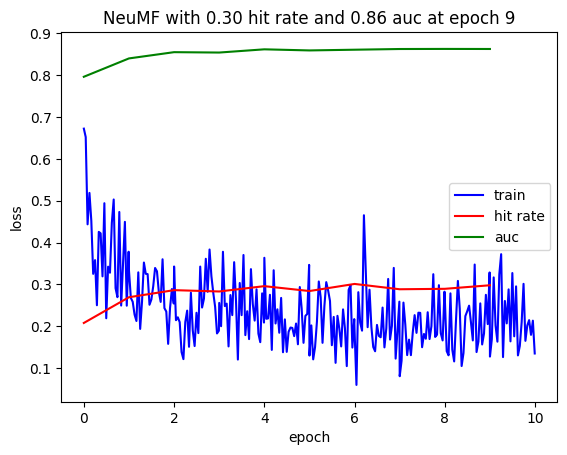

In [7]:
import animator
ani = animator.Animator()
num_epochs = 10
train_epoch_perc = []
train_loss = []
hit_rate_list = []
auc_list = []
epoch_list = []
for epoch in range(num_epochs):
    # metric, l = d2l.Accumulator(3), 0.
    for batch, values in enumerate(train_iter):
        input_data = []
        for v in values:
            input_data.append(v.to(device))
        
        p_pos = model(input_data[0], input_data[1])
        p_neg = model(input_data[0], input_data[-1])
        loss = loss_fn(p_pos, p_neg)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 64 == 0:
            train_epoch_perc.append((batch+1)/ len(train_iter) + epoch)
            train_loss.append(loss.item())

    with torch.no_grad():
        hit_rate, auc = evaluate_ranking(
            model, 
            test_iter,
            candidates, 
            num_users, 
            num_items
        )
        hit_rate_list.append(hit_rate)
        auc_list.append(auc)
        epoch_list.append(epoch)
    # hit_rate, auc = 0,0

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='train')
    ani.ax.plot(epoch_list, hit_rate_list, color='r', label='hit rate')
    ani.ax.plot(epoch_list, auc_list, color='g', label='auc')
    ani.ax.set_xlabel('epoch')
    ani.ax.set_ylabel('loss')
    ani.ax.legend()
    ani.ax.set_title(f'NeuMF with {hit_rate:.2f} hit rate and {auc:.2f} auc at epoch {epoch}')
    ani.render()

ani.close()
